# Full GAN

In [1]:
import librosa
import io
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim

import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
path_models = '/content/gdrive/MyDrive/project_mml/models'
path_music = '/content/gdrive/MyDrive/project_mml/examples'
file_path = "/content/gdrive/MyDrive/project_mml/data/global_stft_stats.pkl"

# Open and load the .pkl file
with open(file_path, 'rb') as file:
    stft_stats = pickle.load(file)

stft_stats

{'magnitude_mean': 0.78685814,
 'magnitude_std': 4.0197673,
 'phase_mean': 0.008972294,
 'phase_std': 1.8158828}

In [5]:
# Abrimos datos preprocesados para el modelo
stft_dataset = torch.load('/content/gdrive/MyDrive/project_mml/data/stft_dataset.pt')
print(stft_dataset)

In [6]:
# Training parameters
batch_size = 32
num_epochs = 2

# Parámetros de STFT y audio
n_fft = 1024
hop_length = 512
sr = 44100  # Frecuencia de muestreo

# Create DataLoader
stft_loader = torch.utils.data.DataLoader(stft_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Number of epochs
num_epochs = 500  # Increased number of epochs

def save_model(model, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, path)

class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=(4, 4), stride=(1, 1), padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 4), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, output_channels, kernel_size=(6, 81), stride=(4, 5), padding=(1, 3), output_padding=(1, 2)),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
latent_dim = 100
generator = Generator(latent_dim, 2).to(device)  # Outputs for magnitude and phase
discriminator = Discriminator(2).to(device)  # Inputs for magnitude and phase

# Learning Rate
lr_d = 1e-5  # Reduced learning rate for discriminator
lr_g = 1e-4

# Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Learning rate scheduler
schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=30, gamma=0.1)
schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=30, gamma=0.1)

# Loss function
criterion = nn.BCELoss()

# Losses
d_losses = []
g_losses = []

# Set initial values
best_g_loss = float('inf')

for epoch in range(num_epochs):
    for (real_stfts,) in stft_loader:
        real_stfts = real_stfts.to(device)
        batch_size = real_stfts.size(0)

        # Create real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator
        optimizerD.zero_grad()

        # Add noise to the real samples
        real_stfts += 0.05 * torch.randn_like(real_stfts)

        outputs = discriminator(real_stfts)
        real_labels_resized = torch.ones_like(outputs) * 0.9  # Label smoothing
        d_loss_real = criterion(outputs, real_labels_resized)

        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_stfts = generator(noise)
        outputs = discriminator(fake_stfts.detach())
        fake_labels_resized = torch.zeros_like(outputs)  # Resize fake labels to match discriminator output
        d_loss_fake = criterion(outputs, fake_labels_resized)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        # Train the generator multiple times
        for _ in range(3):
            optimizerG.zero_grad()
            noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_stfts = generator(noise)
            outputs = discriminator(fake_stfts)
            real_labels_resized = torch.ones_like(outputs)  # Resize real labels to match discriminator output
            g_loss = criterion(outputs, real_labels_resized)
            g_loss.backward()
            optimizerG.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Step the learning rate scheduler
    schedulerG.step()
    schedulerD.step()

    # Save the best model
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        save_model(generator, epoch+1, os.path.join(path_models, f'best_generator.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'best_discriminator.pth'))

    # Save model checkpoints every 50 epochs
    if (epoch + 1) % 50 == 0:
        save_model(generator, epoch+1, os.path.join(path_models, f'generator_epoch_{epoch+1}.pth'))
        save_model(discriminator, epoch+1, os.path.join(path_models, f'discriminator_epoch_{epoch+1}.pth'))

Epoch [1/500], d_loss: 1.6855, g_loss: 0.4274
Epoch [2/500], d_loss: 1.6596, g_loss: 0.4589
Epoch [3/500], d_loss: 1.6035, g_loss: 0.5049
Epoch [4/500], d_loss: 1.5855, g_loss: 0.5490
Epoch [5/500], d_loss: 1.5602, g_loss: 0.6019
Epoch [6/500], d_loss: 1.5551, g_loss: 0.6385
Epoch [7/500], d_loss: 1.5114, g_loss: 0.6684
Epoch [8/500], d_loss: 1.5126, g_loss: 0.6964
Epoch [9/500], d_loss: 1.4756, g_loss: 0.7124
Epoch [10/500], d_loss: 1.4664, g_loss: 0.7298
Epoch [11/500], d_loss: 1.4471, g_loss: 0.7312
Epoch [12/500], d_loss: 1.4561, g_loss: 0.7376
Epoch [13/500], d_loss: 1.4497, g_loss: 0.7386
Epoch [14/500], d_loss: 1.4263, g_loss: 0.7438
Epoch [15/500], d_loss: 1.4353, g_loss: 0.7473
Epoch [16/500], d_loss: 1.4127, g_loss: 0.7491
Epoch [17/500], d_loss: 1.4143, g_loss: 0.7475
Epoch [18/500], d_loss: 1.4063, g_loss: 0.7489
Epoch [19/500], d_loss: 1.3988, g_loss: 0.7490
Epoch [20/500], d_loss: 1.3920, g_loss: 0.7501
Epoch [21/500], d_loss: 1.3983, g_loss: 0.7510
Epoch [22/500], d_loss

In [8]:
print(f"real_stfts.shape: {real_stfts.shape}")
print(f"real_labels.shape: {real_labels.shape}")
print(f"fake_stfts.shape: {fake_stfts.shape}")
print(f"fake_labels.shape: {fake_labels.shape}")

real_stfts.shape: torch.Size([28, 2, 513, 2582])
real_labels.shape: torch.Size([28, 1])
fake_stfts.shape: torch.Size([28, 2, 513, 2582])
fake_labels.shape: torch.Size([28, 1])


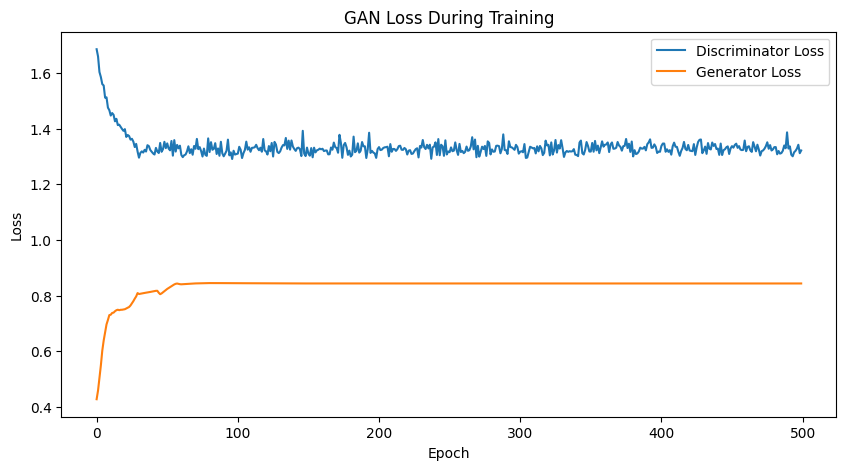

In [9]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Loss During Training')
plt.show()

In [10]:
n_fft = 1024
hop_length = 512
sr = 44100  # Sampling rate

for i in range(10):
  # Generate new magnitudes and phases
  noise = torch.randn(1, latent_dim, 1, 1).to(device)
  generated_stft = generator(noise).detach().cpu().numpy()
  generated_magnitude = generated_stft[:, 0, :, :]
  generated_phase = generated_stft[:, 1, :, :]

  # Denormalize
  generated_magnitude = (generated_magnitude * stft_stats['magnitude_std']) + stft_stats['magnitude_mean']
  generated_phase = (generated_phase * stft_stats['phase_std']) + stft_stats['phase_mean']

  # Combine magnitude and phase to obtain the STFT
  generated_stft = generated_magnitude * np.exp(1j * generated_phase)

  # Convert to audio signal
  generated_audio = librosa.istft(generated_stft[0], hop_length=hop_length, win_length=n_fft)

  # Ensure the audio signal has the correct shape
  if generated_audio.ndim > 1:
      generated_audio = np.squeeze(generated_audio)

  # Ensure the audio signal is in the correct format
  generated_audio = generated_audio.astype(np.float32)

  # Save the generated audio
  sf.write(f'{path_music}/generated_audio_gan_{i+1}.wav', generated_audio, samplerate=sr)

  # Play the generated audio
  ipd.Audio(f'{path_music}/generated_audio_gan_{i+1}.wav')

In [11]:
n_fft = 1024
hop_length = 512
sr = 44100  # Sampling rate

# Generate new magnitudes and phases
noise = torch.randn(1, latent_dim, 1, 1).to(device)
generated_stft = generator(noise).detach().cpu().numpy()
generated_magnitude = generated_stft[:, 0, :, :]
generated_phase = generated_stft[:, 1, :, :]

# Denormalize
generated_magnitude = (generated_magnitude * stft_stats['magnitude_std']) + stft_stats['magnitude_mean']
generated_phase = (generated_phase * stft_stats['phase_std']) + stft_stats['phase_mean']

# Combine magnitude and phase to obtain the STFT
generated_stft = generated_magnitude * np.exp(1j * generated_phase)

# Convert to audio signal
generated_audio = librosa.istft(generated_stft[0], hop_length=hop_length, win_length=n_fft)

# Ensure the audio signal has the correct shape
if generated_audio.ndim > 1:
    generated_audio = np.squeeze(generated_audio)

# Ensure the audio signal is in the correct format
generated_audio = generated_audio.astype(np.float32)

# Save the generated audio
sf.write('generated_audio.wav', generated_audio, samplerate=sr)

# Play the generated audio
ipd.Audio('generated_audio.wav')